In [ ]:
!pip install gensim
!pip install tqdm
!pip install nltk
!pip install transformers
!pip install -U "ray[tune]"
!pip install sklearn
!pip install optuna
!pip install --user fastai

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

import gensim.downloader as api
from tqdm import tqdm
from nltk import word_tokenize
import torch
import multiprocessing

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, DistilBertForSequenceClassification
import sys

sys.path.insert(0, '/home/jupyter/src/natalies-little-helper/util')
import helpers as helper

In [3]:
# Number of CPU cores available
cpu = multiprocessing.cpu_count()

# Set up cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of GPUs being used
gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

# CPU and GPU Resources
proc_resources = {'cpu': cpu, 'gpu': gpu}

In [4]:
data_path = "/home/jupyter/src/natalies-little-helper/data/"

intent = pd.read_csv(data_path + "intent_Tweets.csv", index_col=0)

intentSubGroups = {
    'Customer Service Issue': 'Customer Service Issue',
    'Late Flight': 'Late Flight',
    'Cancelled Flight': 'Cancelled Flight',
    'Lost Luggage': 'Luggage',
    'Bad Flight': 'Bad Flight',
    'Flight Booking Problems': 'Flight Booking Problems',
    'Flight Attendant Complaints': 'Flight Attendant Complaints',
    'longlines': 'Customer Service Issue',
    'Damaged Luggage': 'Luggage',
    'Can\'t Tell': 'Can\'t Tell'
}

intent['negativereason'] = intent.negativereason.apply(lambda x: intentSubGroups[x])

# yLabels = intent.negativereason.astype('category').cat.categories
print("Number of Negative Reasons: ", intent.negativereason.count())
intent.negativereason.value_counts()

Number of Negative Reasons:  9178


Customer Service Issue         3088
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Luggage                         798
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
Name: negativereason, dtype: int64

In [5]:
intent = intent[intent['negativereason'].notna()]
intent.reset_index(drop=True, inplace=True)
num_labels = len(intent.negativereason.unique())

rmap = {reason: i for i, reason in enumerate(intent.negativereason.unique())}
imap = {i: reason for reason, i in rmap.items()}

yLabels = [imap[i] for i in range(len(imap))]

intent.negativereason = intent.negativereason.apply(lambda x: rmap[x])

## Select Samples

In [6]:
intent.intentGroup.value_counts()

Customer Service    4098
Flights             3092
Can't Tell          1190
Luggage              798
Name: intentGroup, dtype: int64

In [7]:
N_SAMPLES = 798
intent_groups_df = intent.groupby('intentGroup').apply(lambda x: x.sample(n=N_SAMPLES)).reset_index(drop=True)
intent_group_labels = intent.intentGroup.astype('category').cat.categories
intent_group_map = {group: i for i, group in enumerate(intent_group_labels)}
intent_groups_df.intentGroup = intent_groups_df.intentGroup.apply(lambda x: intent_group_map[x])

In [8]:
intent_groups_df.intentGroup.value_counts()

0    798
1    798
2    798
3    798
Name: intentGroup, dtype: int64

## Split Train and Test Data

In [9]:
vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.9999, ngram_range=(1,3), max_features=10000)
X = vectorizer.fit_transform(intent.text)

scaler = StandardScaler(with_mean=False)
scaler.fit(X)

xTrain, xTest, yTrain, yTest = train_test_split(X, intent.negativereason, train_size=0.8, stratify=intent.negativereason)

In [10]:
XGroup = vectorizer.fit_transform(intent_groups_df.text)
xGroupTrain, xGroupTest, yGroupTrain, yGroupTest = train_test_split(XGroup, intent_groups_df.intentGroup, train_size=0.8, stratify=intent_groups_df.intentGroup)

# Base Classifiers

## Perceptron

### Intent Reasons

In [11]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scaler.transform(xTrain), yTrain)
# clf.fit(xTrain, yTrain)

# yPred = clf.predict(xTest)

# precisions = precision_score(yTest, yPred, average=None)
# recalls = recall_score(yTest, yPred, average=None)
# f1s = f1_score(yTest, yPred, average=None)

# helper.evaluate_score(yTest, yPred)

OneVsRestClassifier(estimator=Perceptron(n_jobs=-1), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.39      0.21      0.27       116
           1       0.36      0.47      0.41       238
           2       0.62      0.66      0.64       333
           3       0.61      0.72      0.66       618
           4       0.35      0.17      0.23       106
           5       0.72      0.67      0.69       160
           6       0.67      0.21      0.32        96
           7       0.72      0.64      0.68       169

    accuracy                           0.58      1836
   macro avg       0.56      0.47      0.49      1836
weighted avg       0.57      0.58      0.56      1836



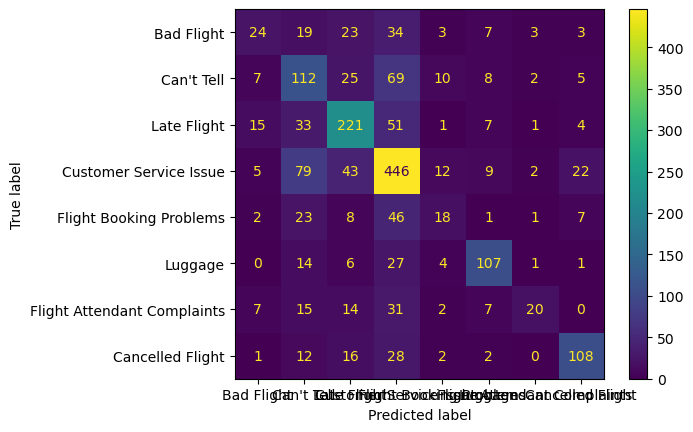

array([3, 7, 3, ..., 3, 2, 1])

In [12]:
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [13]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scaler.transform(xGroupTrain), yGroupTrain)

OneVsRestClassifier(estimator=Perceptron(n_jobs=-1), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.52      0.57      0.55       160
           1       0.63      0.52      0.57       159
           2       0.66      0.66      0.66       160
           3       0.74      0.80      0.77       160

    accuracy                           0.64       639
   macro avg       0.64      0.64      0.64       639
weighted avg       0.64      0.64      0.64       639



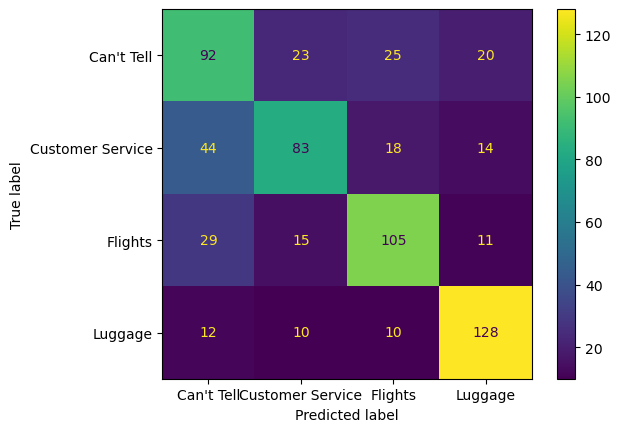

In [14]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

## Logistic Regression

### Intent Reasons

In [15]:
clf = LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)
clf.fit(xTrain, yTrain)

yPred = clf.predict(xTest)

helper.evaluate_score(yTest, yPred)

Accuracy:	 0.6111111111111112
Precision:	 [0.48979592 0.425      0.67323944 0.58421673 0.48       0.81203008
 0.59375    0.859375  ]
Recall: 	 [0.20689655 0.42857143 0.71771772 0.802589   0.22641509 0.675
 0.19791667 0.65088757]
F1 scores:	 [0.29090909 0.42677824 0.69476744 0.67620995 0.30769231 0.73720137
 0.296875   0.74074074]
Average
	Precision: 0.6134205786224473
	Recall: 0.6111111111111112
	F1: 0.5930429047844025


1836
1836
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}
              precision    recall  f1-score   support

           0       0.49      0.21      0.29       116
           1       0.42      0.43      0.43       238
           2       0.67      0.72      0.69       333
           3       0.58      0.80      0.68       618
           4       0.48      0.23      0.31       106
           5       0.81      0.68      0.74       160
           6       0.59      0.20      0.30        96
           7       0.86      0.65      0.74       169

    accuracy                           0.61      1836
   macro avg       0.61      0.49      0.52      1836
weighted avg       0.61      0.61      0.59      1836



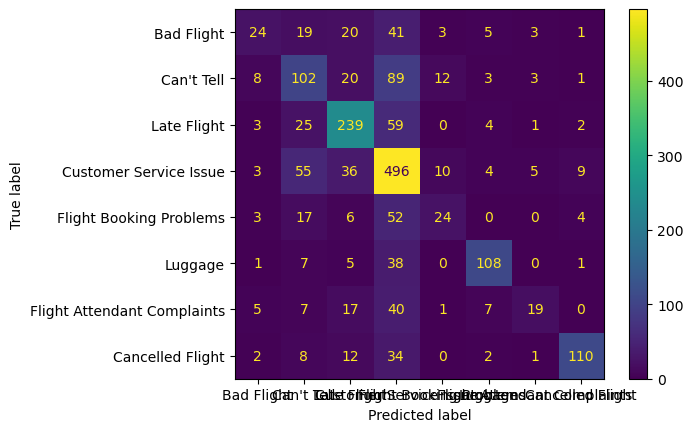

array([3, 7, 3, ..., 3, 2, 1])

In [16]:
print(len(yPred))
print(len(yTest))
ySet = {y for y in yPred}
yTSet = {y for y in yTest}
print(ySet)
print(yTSet)
# helper.evaluate_score([0,1,2,3,4], [1,2,0,3,3])
# helper.evaluate_score(yTest, yPred)
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [17]:
clf = LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)
clf.fit(xGroupTrain, yGroupTrain)

LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.57      0.68      0.62       160
           1       0.65      0.58      0.61       159
           2       0.70      0.67      0.68       160
           3       0.83      0.79      0.81       160

    accuracy                           0.68       639
   macro avg       0.69      0.68      0.68       639
weighted avg       0.69      0.68      0.68       639



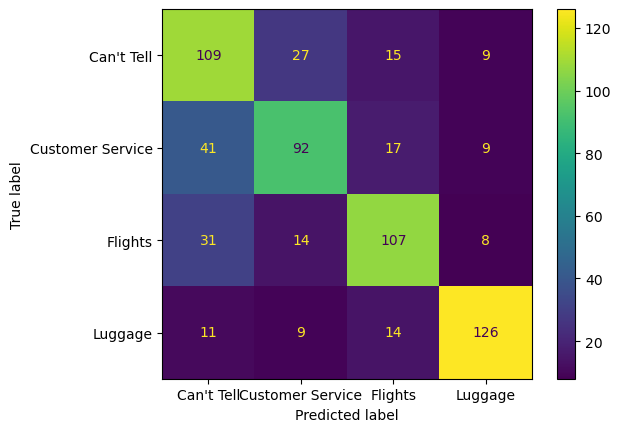

In [18]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

## SVC

### Intent Reasons

In [19]:
clf = LinearSVC()
clf.fit(xTrain, yTrain)

# yPred = clf.predict(xTest)

# helper.evaluate_score(yTest, yPred)

LinearSVC()

              precision    recall  f1-score   support

           0       0.41      0.22      0.29       116
           1       0.40      0.41      0.41       238
           2       0.63      0.70      0.66       333
           3       0.61      0.73      0.67       618
           4       0.43      0.28      0.34       106
           5       0.75      0.76      0.75       160
           6       0.49      0.24      0.32        96
           7       0.78      0.64      0.71       169

    accuracy                           0.60      1836
   macro avg       0.56      0.50      0.52      1836
weighted avg       0.59      0.60      0.58      1836



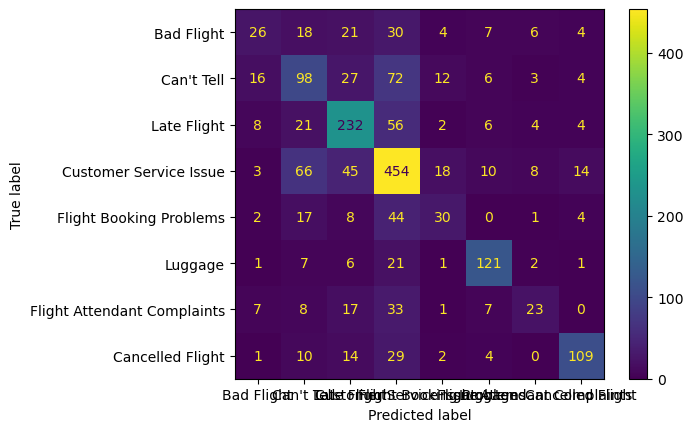

array([3, 7, 3, ..., 3, 2, 1])

In [20]:
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [21]:
clf = LinearSVC()
clf.fit(xGroupTrain, yGroupTrain)

LinearSVC()

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       160
           1       0.62      0.57      0.59       159
           2       0.73      0.68      0.70       160
           3       0.82      0.79      0.81       160

    accuracy                           0.67       639
   macro avg       0.67      0.67      0.67       639
weighted avg       0.67      0.67      0.67       639



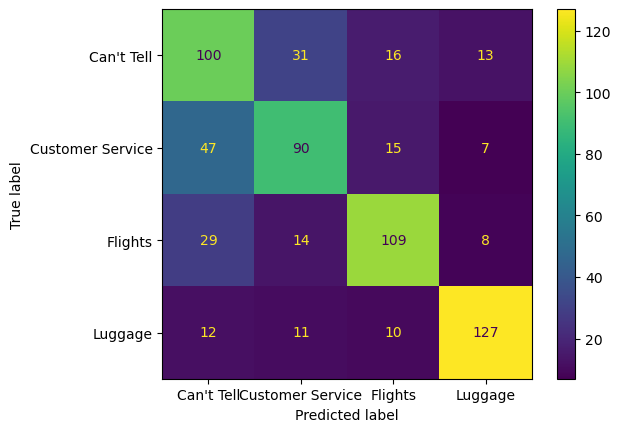

In [22]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

# Advance Models

In [23]:
from fastai.text.all import *
from fastai import *

In [24]:
# data_lm = (TextList
#            .from_csv(path, data_path + 'Tweets.csv', cols='text')
#            #Where are the text? Column 'text' of tweets.csv
#            .split_by_rand_pct(0.2)
#            #How to split it? Randomly with the default 20% in valid
#            .label_for_lm()
#            #Label it for a language model
#            .databunch(bs=48))
#            #Finally we convert to a DataBunch
# data_lm.show_batch()

train= pd.read_csv(data_path + 'Tweets.csv')

data_lm = DataBlock(
        blocks=TextBlock.from_df('text', is_lm=True),
        get_x=ColReader('text'),
        splitter=RandomSplitter(0.2)
)

data_lm = data_lm.dataloaders(train, bs=10, seq_len=72, device=torch.device('cuda'))
data_lm.show_batch()

,text,text_
0,xxbos @united yes i have xxbos @southwestair xxmaj why do airlines change ticket prices in the middle of the day \n▁ # annoyed xxbos @usairways i would be willing to pay anything to change a flight ! xxunk does not ! help ! xxbos @americanair - do n't understand why i have zero xxmaj flt xxunk no xxunk 2 he wait time on ph xxunk so much for xxmaj xxunk xxmaj mem,@united yes i have xxbos @southwestair xxmaj why do airlines change ticket prices in the middle of the day \n▁ # annoyed xxbos @usairways i would be willing to pay anything to change a flight ! xxunk does not ! help ! xxbos @americanair - do n't understand why i have zero xxmaj flt xxunk no xxunk 2 he wait time on ph xxunk so much for xxmaj xxunk xxmaj mem :(
1,for keeping me on hold xxunk . xxmaj next rep was not able to track name xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” 😂 😂 xxbos @usairways so i guess you are ok with people being xxunk assaulted on your flights nice customer service xxbos @southwestair 3 + hrs w / out bags being returned to us after flight xxunk,keeping me on hold xxunk . xxmaj next rep was not able to track name xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” 😂 😂 xxbos @usairways so i guess you are ok with people being xxunk assaulted on your flights nice customer service xxbos @southwestair 3 + hrs w / out bags being returned to us after flight xxunk xxmaj
2,us know soon what they decide . # xxunk # xxunk xxbos @southwestair - thanks for xxmaj cancelled xxmaj flighting our flight to xxup bos . xxmaj we 're stranded in xxup den til xxmaj we d night . xxmaj the 7 of us will never fly # southwest again xxbos @southwestair broke the stroller my wife and baby gate checked . xxmaj they told her it 's not their problem .,know soon what they decide . # xxunk # xxunk xxbos @southwestair - thanks for xxmaj cancelled xxmaj flighting our flight to xxup bos . xxmaj we 're stranded in xxup den til xxmaj we d night . xxmaj the 7 of us will never fly # southwest again xxbos @southwestair broke the stroller my wife and baby gate checked . xxmaj they told her it 's not their problem . xxmaj
3,"can i put sun in my carry on ? xxup rt “ @united : xxunk xxrep 3 e xxmaj right now 0 would be a heat xxunk , so enjoy the warmth ! xxmaj can you bring some home ? xxunk ” xxbos @united fire yr rep who refused to put me on a flight that i had a boarding pass and seat on . xxmaj full explanation and her name in","i put sun in my carry on ? xxup rt “ @united : xxunk xxrep 3 e xxmaj right now 0 would be a heat xxunk , so enjoy the warmth ! xxmaj can you bring some home ? xxunk ” xxbos @united fire yr rep who refused to put me on a flight that i had a boarding pass and seat on . xxmaj full explanation and her name in complaint"
4,"planes , the sun xxunk can stay down ? xxmaj other carriers make you raise them ? xxbos @virginamerica xxmaj your website is down and xxmaj i 'm trying to check in ! xxbos @southwestair xxmaj i 've been on hold for the last 2 hours - no progress # xxunk # stranded # xxunk # xxunk xxmaj flightr xxbos @southwestair where are our pilots ? xxmaj plane is here flight says",", the sun xxunk can stay down ? xxmaj other carriers make you raise them ? xxbos @virginamerica xxmaj your website is down and xxmaj i 'm trying to check in ! xxbos @southwestair xxmaj i 've been on hold for the last 2 hours - no progress # xxunk # stranded # xxunk # xxunk xxmaj flightr xxbos @southwestair where are our pilots ? xxmaj plane is here flight says it"
5,warm weather ! xxbos @usairways flight xxunk sitting fully loaded for over an hour . xxmaj air xxunk barely working :-( xxbos @southwestair thank you so much completely made things right ! xxbos @usairways this is got to be the worst service xxmaj i 've ever seen with an airline . 3 xxmaj cancelled xxmaj flightled flights . xxmaj rude employees . xxmaj currently flight delayed xxbos @united xxmaj great ! xxmaj,weather ! xxbos @usairways flight xxunk sitt

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
# learn.model = learn.cuda()
# #find the optimal learning rate & visualize it
learn.lr_find();
learn.recorder.plot();

In [ ]:
learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

# Distilbert Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", Truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

In [ ]:
data_og = pd.concat([intent.text, intent.negativereason], axis=1)

data = []
for t in data_og.iterrows():
    temp = {}
    temp["text"] = t[1].text
    temp["label"] = t[1].negativereason
    temp.update(tokenizer(t[1].text))
    data.append(temp)

train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [ ]:
def model_init():
    return DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels, force_download=True, cache_dir="/home/jupyter/cache/")

training_args = TrainingArguments(
    output_dir="./intent_results",
    learning_rate=2e-5,
    evaluation_strategy = "steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_steps=100,
    eval_steps=100
)

trainer_tuned = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
best_run = trainer_tuned.hyperparameter_search(n_trials=1, direction="maximize")

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer_tuned.args, n, v)

trainer_tuned.train()

In [ ]:
preds = trainer_tuned.predict(test_dict)

In [ ]:
yTrue = [t["label"] for t in test_dict]
yPred = [p.argmax() for p in preds[0]]
helper.evaluate_score(yTrue, yPred)